# [E-07] 프로젝트: 뉴스기사 요약해보기

<br>

---

**뉴스기사 데이터셋에 대해 추상적 / 추출적 요약을 모두 진행해보자**

<br>
- 주요 라이브러리 버전 확인

---

In [177]:
from importlib.metadata import version
import nltk
import tensorflow
import summa

print(nltk.__version__)
print(tensorflow.__version__)
print(version('summa'))

3.6.5
2.6.0
1.2.0


### ✔️ 필요한 라이브러리 import하기

---

In [178]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### ✔️ 데이터 수집하기

---

In [179]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print(data.shape)
print(data.columns)

data=data[['text', 'headlines']]

(98401, 2)
Index(['headlines', 'text'], dtype='object')


In [180]:
# 98401개의 뉴스 기사 중 10개의 랜덤한 기사를 출력해보고 데이터를 제대로 불러왔는지 확인해보자

data.sample(10)

,text,headlines
73505,Actress Priyanka Chopra's Sikkimese production...,Priyanka's Sikkimese production to premiere at...
77218,Several private schools in Haryana's Rohtak we...,Rohtak schools declare holiday as buses used f...
4900,PM Narendra Modi has inaugurated or laid found...,"PM Modi unveils projects worth over Ã¢ÂÂ¹14,0..."
78068,A school teacher in Odisha's Angul district ma...,School teacher makes students wash scooter for...
403,An 81-year-old woman named Eileen Macken who g...,I'm no more an orphan: Woman finds 103-yr-old ...
78157,A 13-by-7 meter billboard depicting US Preside...,Donald Trump appears as alien on billboard in ...
13890,"Kangana Ranaut, while speaking about the #MeTo...",Some people keep wives as trophies: Kangana on...
19776,A video of an Assistant Sub-Inspector in Punja...,"Cop beats elderly woman, drags her by her hair..."
41531,Apple has rolled out iOS 11.3 update for iPhon...,"Apple releases iOS 11.3 with battery features,..."
97965,Electronics company LG has been sued by four G...,LG sued over flaw that made smartphones unusable


<br>
- 추상적 요약을 하는 경우 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습한다.
<br><br>
- 추출적 야약을 하는 경우에는 오직 text 열만을 사용한다.

<br>

---


# Ⅰ. 추상적 요약

---

<br><br>

<br>

### ✔️ Step 1. 데이터 전처리하기
#### (1) 데이터 정리하기
---

**⭐ 1) 중복 샘플과 NULL 값이 존재하는 샘플 제거<br>**

In [181]:
print('수집된 뉴스기사 샘플의 수 :', len(data))
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

수집된 뉴스기사 샘플의 수 : 98401
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [182]:
data['headlines'].value_counts()

Warne produced 'ball of century' with his 1st Ashes delivery         3
Indian spinner once bowled record 21 maiden overs in a row           3
Don Bradman once scored 100 runs in 3 overs                          3
CARS24 enables car owners to sell their cars in less than 2 hours    3
A solar eclipse once proved Einstein right, Newton wrong             3
                                                                    ..
Xiaomi files for world's biggest IPO since Alibaba in 2014           1
Wife of automobile inventor made the world's first road trip         1
Punished for serving the country: Ex-Pak PM Nawaz Sharif             1
NASA prepares a new set of twin satellites to track ice melt         1
Madhesi Morcha withdraws support to Nepalese government              1
Name: headlines, Length: 98280, dtype: int64

<br>

- 기사의 원문인 `text`열에서는 41개의 중복된 기사기 존재하고, 요약본인 `headlines`열에서는 121개의 중복된 요약이 존재한다.<br><br>
- `drop_duplicates()` 매서드를 사용해서 `text`열의 중복된 기사원본을 제거하도록 한다.<br><br>
- `headlines`의 경우는 기사가 유사한 내용을 다루고 있는 경우, 중복된 요약을 할 수 있을 것으로 간주하여 중복된 요약은 그대로 두기로 한다.<br><br>

In [183]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꾼다.

data.drop_duplicates(subset=['text'], inplace=True)
print('전체 샘플수 :', len(data))

전체 샘플수 : 98360


<br>
- 중복된 샘픙을 제거하였음에도 결측 샘플데이터에 대한 전처리또한 진행해주어야 한다.<br><br>

In [184]:
print(data.isnull().sum())

text         0
headlines    0
dtype: int64


<br>
- 결측 샘플데이터는 없으므로 중복된 기사 및 결측 데이터 전치리를 마무리한다.<br><br>

<br><br>
**⭐ 2) 텍스트 정규화와 불용어 제거**

---

**※ 텍스트 정규화란 ?**
- 같은 의미인데 다른 표현으로 사용된 단어들을 정리해주는 것.
- ex) `it'll == it will`

In [185]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


<br>

- 앞서 노드에서 정의해 두었던 정규화 사전을 사용하도록 한다.<br><br>
- **불용어(stopwords)**라고 불리는 일반적으로 텍스트에 자주 등장하지만 자연어 처리할 때 실질적으로 도움이 되지 않는 단어들을 제거해야함.<br><br>
    - `NLTK`에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거한다.<br><br>
    - 추가적으로 모든 영어 문자는 소문자로, 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 처리해야 함.<br><br>

In [186]:
print('불용어 갯수 :', len(stopwords.words('english')))
print(stopwords.words('english'))

불용어 갯수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [187]:
# 데이터 전처리 정제 함수

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, 'lxml').text # <br />, <a href = ...>등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
    

In [188]:
clean_text = []
# 전체 text 데이터에 대한 전처리
for i, s in enumerate(data['text']):
    clean_text.append(preprocess_sentence(s))
    if i % 9000 == 0:
        print(f"{round(100*i/len(data['text']),2)} % complete.")
    
# 전처리 후 출력
print('\ntext 전처리 후 결과 :', clean_text[:5])

0.0 % complete.
9.15 % complete.
18.3 % complete.
27.45 % complete.
36.6 % complete.
45.75 % complete.
54.9 % complete.
64.05 % complete.
73.2 % complete.
82.35 % complete.
91.5 % complete.

text 전처리 후 결과 : ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting se

In [189]:
clean_headlines = []
# 전체 text 데이터에 대한 전처리
for i, s in enumerate(data['headlines']):
    clean_headlines.append(preprocess_sentence(s))
    if i % 9000 == 0:
        print(f"{round(100*i/len(data['headlines']),2)} % complete.")
    
# 전처리 후 출력
print('\nheadlines 전처리 후 결과 :', clean_headlines[:5])

0.0 % complete.
9.15 % complete.
18.3 % complete.
27.45 % complete.
36.6 % complete.
45.75 % complete.
54.9 % complete.
64.05 % complete.
73.2 % complete.
82.35 % complete.
91.5 % complete.

headlines 전처리 후 결과 : ['upgrad learner switches career ml al salary hike', 'delhi techie wins free food swiggy one year cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'known hirani yrs metoo claims true sonam']


<br>

- 텍스트 정제의 과정을 거친 후 다시 한번 빈(empty) 샘플이 생겼는지 확인해보자.<br>왜냐하면, 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있다.<br><br>

In [190]:
# 정제된 리스트 객체들을 다시 data 데이터프레임으로 재 저장한다.

data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 null 값으로 변환
data.replace('', np.nan, inplace=True)

In [191]:
# data 내에 null 값이 있는지 확인한다.
data.isnull().sum()

text         0
headlines    0
dtype: int64

In [192]:
data.dropna(axis=0, inplace=True)
print('전체 샘플 수 :', len(data))

전체 샘플 수 : 98360


<br><br>
**⭐ 3) 샘플의 최대 길이 정하기**

---

- 필요없는 단어를 모두 솎아낸 데이터를 가지게 되었다. 이제는 훈련에 사용할 샘플의 최대 길이를 지정해보자

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 13
헤드라인의 평균 길이 : 7.136183407889386


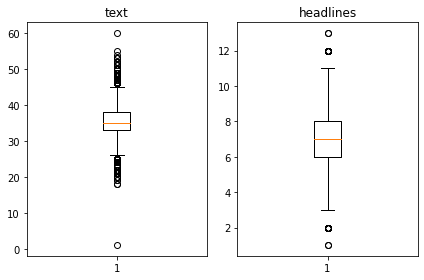

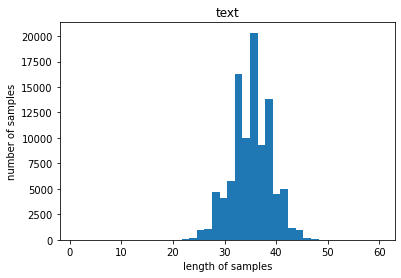

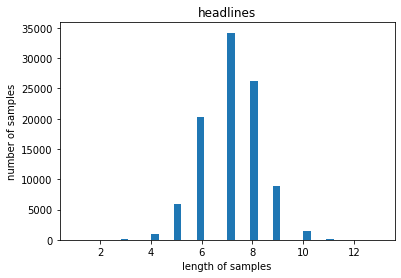

In [193]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(121)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(122)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [194]:
# 위 통계적인 데이터 값을 통해 text와 headlines의 최대 길이를 임의로 정해본다.

text_max_len = 40
headlines_max_len = 8

In [195]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [196]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.8925782838552258


- 40과 8로 text와 headlines를 각각 패딩하게 되면 해당 길이보다 긴 샘플들은 잘리게 된다.<br>text의 경우 약 8%, headlines의 경우 약 10% 샘플의 내용이 망가지게 된다.<br><br>

In [197]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 81914


△ `text`와 `headlines`의 최대길이를 설정하여 최대길이를 넘어서는 샘플은 제외시켰더니, 전체 샘플수는 98360 >>> 81914로 줄었다.<br><br>

<br><br>
**⭐ 4) 시작토큰과 종료토큰 추가하기**

---

- `seq2seq` 모델 훈련을 위해 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가해야한다.<br>디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 `decoder_input`, <br>디코더의 출력 또는 레이블에 해당하면서 종료 토큰이 맨 뒤에 붙는 문장의 이름은 `decoder_target`이라고 이름을 정했다.<br><br>
- 우리의 목표인 텍스트 문장을 읽고 요약을 하기위한 것으로 두 문장 모두 `headlines` 열로부터 만들기로 한다.

In [198]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x:'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,text,headlines,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches career ml al salary hike,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
4,speaking sexual harassment allegations rajkuma...,known hirani yrs metoo claims true sonam,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken
6,india recorded lowest odi total new zealand ge...,india get lowest odi total new zealand,sostoken india get lowest odi total new zealand,india get lowest odi total new zealand eostoken
7,weeks ex cbi director alok verma told departme...,govt directs alok verma join work day retirement,sostoken govt directs alok verma join work day...,govt directs alok verma join work day retireme...
9,congress candidate shafia zubair ramgarh assem...,cong wins ramgarh bypoll rajasthan takes total...,sostoken cong wins ramgarh bypoll rajasthan ta...,cong wins ramgarh bypoll rajasthan takes total...


In [199]:
# 인코더의 입력, 디코더의 입력과 디코더의 레이블을 각각 다시 Numpy 타입으로 저장한다.

encoder_input = np.array(data['text'])  # 인코더의 입력
decoder_input = np.array(data['decoder_input'])  # 디코더의 입력
decoder_target = np.array(data['decoder_target'])  # 디코더의 레이블

<br>

- 이제 훈련데이터와 테스트데이터를 분리하는데 직접 코딩을 통해 분리하는 방법을 사용한다.<br>
- `encoder_input`과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만든다.<br><br>

In [200]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[69602   336 68984 ... 65634 49461 36983]


- 정수 시퀀스를 통해 다시 데이터의 샘플 순서를 정의해주면 잘 섞인 샘플이 된다.

In [205]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

- 이제 섞인 데이터를 8:2 비율로 훈련 데이터와 검증데이터로 분리한다.

In [206]:
n_of_val = int(len(encoder_input)*0.2)
print('검증 데이터의 수 :', n_of_val)

검증 데이터의 수 : 16382


In [207]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 갯수 :', len(encoder_input_train))
print('훈련 레이블의 갯수 :', len(decoder_input_train))
print('검증 데이터의 갯수 :', len(encoder_input_test))
print('검증 레이블의 갯수 :', len(decoder_input_test))

훈련 데이터의 갯수 : 65532
훈련 레이블의 갯수 : 65532
검증 데이터의 갯수 : 16382
검증 레이블의 갯수 : 16382


<br><br>
**⭐ 5) 단어집합(vocabulary) 만들기 및 정수 인코딩**

---

- 이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련데이터와 검증데이터의 단어들을 모두 정수로 바꾸어 주어야 한다.<br>이를 위해서 각 단어에 고유한 정수를 맵핑하는 작업이 필요한데 이 과정을 **단어집합(vocabulary)**를 만든다고 표현한다.

#### 5-1) `text` 데이터 정수 인코딩<br><br>

In [208]:
src_tokenizer = Tokenizer()  # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train)  # 입력된 데이터로부터 단어 집합 생성

In [209]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 63010
등장 빈도가 6번 이하인 희귀 단어의 수: 43029
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19981
단어 집합에서 희귀 단어의 비율: 68.28916045072211
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.8922473220914204


- `encoder_input_train`에는 6만여개의 단어가 있다.<br>
- 등장빈도가 threshold 값이 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 약 70%를 차지한다. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.8 밖에 되지 않는다.<br><br>
- 따라서, 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 한다.<br>위에서 이를 제외한 단어 집합의 크기를 어림잡아 20,000으로 제한한다. 
    - 토크나이저를 정의할 때, `num_words`의 값을 정해주면, 단어 집합의 크기를 제한할 수 있다.<br><br>

In [210]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab)  # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train)  # 단어 집합 재생성

- `text_to_sequences()`는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행함.

In [211]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print('encoder_input_train ::')
print(encoder_input_train[:3])
print('\nencoder_input_val ::')
print(encoder_input_test[:3])

encoder_input_train ::
[[71, 1590, 309, 3110, 592, 2072, 309, 6359, 826, 629, 6088, 3499, 2706, 223, 3870, 712, 2242, 309, 5453, 1488, 3110, 23, 1265, 798, 1, 77, 1022, 3745, 680, 1079, 973, 953, 4795, 2431, 309, 406], [419, 14, 2889, 2397, 58, 6638, 208, 10253, 826, 471, 4876, 10563, 8900, 13, 1412, 6833, 14938, 3268, 16531, 8722, 4796, 8722, 11858, 2824, 195, 103, 3435, 4620, 23, 5454, 1412, 761, 13, 2160, 726], [865, 3048, 31, 69, 194, 6089, 4, 2200, 54, 31, 485, 6089, 75, 173, 3154, 1728, 954, 1548, 17, 1144, 45, 6089, 390, 19982, 13187, 7061, 51, 181, 14295, 1773]]

encoder_input_val ::
[[147, 4536, 10233, 13, 557, 8889, 3738, 13, 91, 48, 193, 2107, 2125, 980, 13, 117, 48, 8370, 496, 321, 5922, 4774, 466, 17146, 3082, 1090, 82, 299, 11331, 1647, 343, 1647, 363, 4536, 2125, 2], [231, 1686, 94, 153, 60, 12055, 1021, 483, 140, 7, 647, 1369, 3868, 2243, 18708, 165, 2544, 1805, 1258, 67, 133, 66, 1066, 7, 234, 146, 8, 1074], [2697, 76, 500, 14962, 155, 307, 1403, 89, 2034, 203, 11, 394

#### 5-2) `headlines` 데이터 정수 인코딩<br><br>

In [212]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [213]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27498
등장 빈도가 5번 이하인 희귀 단어의 수: 18258
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9240
단어 집합에서 희귀 단어의 비율: 66.39755618590442
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.827360653638892


- 등장빈도가 5회 이하인 단어들은 단어 집합에서 약 70%를 차지하고 있다. 실제 훈련 데이터에서 등장 빈도로 차지하는 비중은 5.87% 밖에 되지 않는다.

In [214]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 11, 1346, 2314], [1, 260, 3691, 7206, 906], [1, 126, 5060, 4625, 32, 3], [1, 1052, 33, 5630, 137, 303, 3052, 1579], [1, 317, 4131, 55, 1692, 2129, 135, 2315]]
target
decoder  [[11, 1346, 2314, 2], [260, 3691, 7206, 906, 2], [126, 5060, 4625, 32, 3, 2], [1052, 33, 5630, 137, 303, 3052, 1579, 2], [317, 4131, 55, 1692, 2129, 135, 2315, 2]]


- `decoder_input_train`과 `decoder_target_train`에는 더 이상 숫자 9000이 넘는 숫자들은 존재하지 않는다. <br><br>
- 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다 따라서, 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty)샘플이 되었다.<br>
- 헤드라인에서 실제 길이가 1로 나오는 인덱스를 `drop_train`과 `drop_test` 변수에 저장 후 샘플들을 모두 삭제한다.<br>

In [215]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 2
훈련 데이터의 개수 : 65531
훈련 레이블의 개수 : 65531
테스트 데이터의 개수 : 16380
테스트 레이블의 개수 : 16380


<br><br>
**⭐ 6) 패딩하기**

---

- 텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 `패딩`작업을 해주어야 한다.
- 미리 정해두었던 최대길이로 패딩한다.

In [216]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

<br>

### ✔️ Step 2. 모델 설계하기
---

**⭐ 1) 인코더 설계**
<br>

- 함수형 API를 이용해서 인코더를 설계한다.

In [217]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더 설계
encoder_inputs = Input(shape=(text_max_len,))  # text_max_len = 50

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs) # src_vocab = 2000

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

- 임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기는 256으로 정의했다. <br>(hidden state는 LSTM에서 얼만큼의 수용력(capacity)을 가질지 정하는 파라미터이다. 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 갯수라고 이해할 수 있다.)<br><br>
- 인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였다. <br>
- hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있다.

**⭐ 2) 디코더 설계**
<br>


In [218]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)  # tar_vocab = 9000
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
# 디코더의 LSTM을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어준다.

# 디코더 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')  
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

<br>

**⭐ 3) 모델 정의**
<br>


In [219]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 128)      2560000     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 40, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

- 디코더의 출력층에서는 `tar_vocab`의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 하므로, Dense 인자로 `tar_vocab`을 주고, 활성화 함수로 소프트맥스를 사용한다.<br><br>
- 여태껏 설계한 모델은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 `seq2seq` 이다.<br><br>
- `attention mechanism`을 적용하여 디코더 출력층의 설계를 바꾸고 성능을 높여보자.

<br>

**⭐ 4) 어텐션 메커니즘**
<br>


- 어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 것이지만 여기서는 TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 배워본다.<br><br>
- `Bahdanau` 스타일의 어텐션 메커니즘을 사용한다.

In [220]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 128)      2560000     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 40, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

<br>

### ✔️ Step 3. 모델 훈련하기
---

In [221]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
256/256 [==============================] - 25s 81ms/step - loss: 6.5107 - val_loss: 6.1406
Epoch 2/50
256/256 [==============================] - 20s 78ms/step - loss: 6.0119 - val_loss: 5.7853
Epoch 3/50
256/256 [==============================] - 20s 77ms/step - loss: 5.6514 - val_loss: 5.4710
Epoch 4/50
256/256 [==============================] - 19s 76ms/step - loss: 5.3624 - val_loss: 5.2695
Epoch 5/50
256/256 [==============================] - 20s 76ms/step - loss: 5.1182 - val_loss: 5.1139
Epoch 6/50
256/256 [==============================] - 20s 77ms/step - loss: 4.9073 - val_loss: 4.9763
Epoch 7/50
256/256 [==============================] - 20s 77ms/step - loss: 4.7209 - val_loss: 4.8812
Epoch 8/50
256/256 [==============================] - 20s 77ms/step - loss: 4.5548 - val_loss: 4.7982
Epoch 9/50
256/256 [==============================] - 20s 77ms/step - loss: 4.4045 - val_loss: 4.7377
Epoch 10/50
256/256 [==============================] - 20s 77ms/step - loss: 4.271

- 조기 종료를 뜻하는 `EarlyStopping`은 특정 조건이 충족되면 훈련을 멈추는 역할을 한다.<br><br>
    - 위 코드에서는 `val_loss`(검증데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patient=2) 관측되면 학습이 멈추도록 설정되었다.

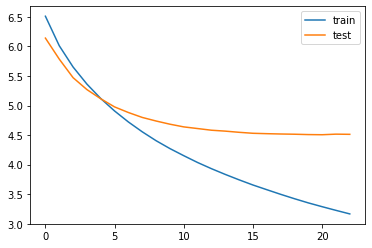

In [222]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

<br>

### ✔️ Step 4. 인퍼런스 모델 구현하기
---

- 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 미리 준비해둔다.

In [223]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 헤드라인 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 헤드라인 단어 집합에서 정수 -> 단어를 얻음

- `seq2seq` 모델은 훈련할 때와 인퍼런스(실제 동작)할 때의 방식이 다르다.<br><br>
    - 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비하면 된다.<br><br>
    - 인퍼런스 단계(정답 문장이 없는)에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 한다.<br><br>        
        - 이때는 인코더 모델과 디코더 모델을 분리해서 설계한다.

In [224]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

# 디코더 임베딩 층
dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


- 어텐션 메커니즘을 사용하는 출력층을 설계한다.

In [225]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

- 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [226]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # <sos>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:  # stop_condition이 True가 될 때까지 루프 반복
        
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]
        
        if sampled_token != 'eostoken':
            decoded_sentence += ' '+sampled_token
        
        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True
            
        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0,0] = sampled_token_index
        
        # 상태를 업데이트
        e_h, e_c = h, c
        
    return decoded_sentence

<br>

### ✔️ Step 5. 모델 테스트하기
---

- 테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는것이 편하다. 따라서, 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만든다.<br><br>
    - text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고, headlines의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만든다.

In [227]:
# text의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if i!=0:
            temp = temp + src_index_to_word[i]+' '
    return temp
    
# headlines의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i]+' '
    return temp

In [297]:
for i in range(2,10):
    print('text                  :', seq2text(encoder_input_test[i]))
    print('\n실제 headlines        :', seq2headlines(decoder_input_test[i]))
    print('\n추상적 요약 headlines :', decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print('\n===============================================================================================\n')

text                  : irrfan khan starrer karwaan released today little wrote hindustan times film leaves warm feeling heart said times india indian express wrote karwaan aiming charm rated 

실제 headlines        : irrfan khan starrer hits theatres 

추상적 요약 headlines :  irrfan khan starrer hits theatres


text                  : supreme court removed ban entry women kerala sabarimala temple head priest friday said disappointed verdict accept meanwhile board president said file review petition getting support religious heads 

실제 headlines        : sc order women entry disappointing sabarimala head priest 

추상적 요약 headlines :  sabarimala temple verdict sabarimala


text                  : uk government considering scrapping jail terms six months less england wales bid ease pressure prisons justice minister stewart said around criminals including burglars could spared jail every year proposed move according reports exceptions would made violent sex offenders 

실제 headlines        : uk m

<br>

---


# Ⅱ. 추출적 요약

---

<br><br>

**⭐ 1) 중복 샘플과 NULL 값이 존재하는 샘플 제거<br>**

In [284]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print(data.shape)
print(data.columns)

data=data[['text', 'headlines']]

(98401, 2)
Index(['headlines', 'text'], dtype='object')


In [285]:
print('수집된 뉴스기사 샘플의 수 :', len(data))
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

수집된 뉴스기사 샘플의 수 : 98401
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [286]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꾼다.

data.drop_duplicates(subset=['text'], inplace=True)
print('전체 샘플수 :', len(data))

전체 샘플수 : 98360


In [287]:
print(data.isnull().sum())

text         0
headlines    0
dtype: int64


<br>

### ✔️ Step 1. Summarize 사용하기
---

In [288]:
import requests
from summa.summarizer import summarize

<br>

**Summa의 summarize()의 인자로 사용되는 값들에 대해서 알아보자.**
<br>

> text(str) : 요약할 텍스트,<br>
> ratio(float, optional) - 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값<br>
> words(int or None, optional) - 출력에 포함할 단어 수.<br>
> 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.<br>
> split(bool, optional) - True면 문장 list , False는 조인(join)된 문자열을 반환<br>

<br>

### ✔️ Step 2. 모델 테스트하기
---

In [298]:
for i in range(2,10):
    print('text                  :', data['text'][i])
    print('\n실제 headlines        :', data['headlines'][i])
    print('\n추출적 요약 headlines :', summarize(text[i], ratio=1/len(text[i].split('. '))))
    print('\n===============================================================================================\n')

text                  : New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.

실제 headlines        : New Zealand end Rohit Sharma-led India's 12-match winning streak

추출적 요약 headlines : The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.


text                  : With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.

실제 headlines        : Aegon life

<br>

---


# . Ⅲ 정리

---

<br><br>

- 확실히 자연어 처리(Natural Language Processing)는 전처리 작업 서부터 모델학습 그리고 인퍼런스 모델까지 정말 다양한 과정을 수행해야만 테스트를 진행할 수 있었다. <br><br>

--- 
- **1. 전처리를 하기위해...** <br><br>
    - 첫번째로, 데이터를 정리하였는데 1) 중복된 문장이 있는지 살펴보았고 2) 빈 문장을 제거하였다. 3) 텍스트 정규화를 진행하였으며 4) NLTK(Natural Language Toolkit)를 사용하여 불용어 처리를 진행하였다.
    - 두번째로, 훈련데이터와 테스트 데이터로 나누었다.
    - 세번째로, 정수 인코딩을 진행하였다.<br><br>
- **2, 모델 설계하기**<br>
- **3, 모델 훈련하기**<br>
- **4, 인퍼런스 모델 구현하기**<br>
- **5, 모델 테스트하기**<br>
- **6, 추출적 요약 해보기**<br><br>

- 모델학습은 안정적으로 수렴됨을 그래프를 통해 확인하였다.
![image](https://user-images.githubusercontent.com/103712369/169865722-1e837470-d302-4b49-85ed-4d945d1f46dc.png)<br>
- Early Stopping 기능을 사용해서 val loss가 두번 이상 줄어들지 않으면 멈추는 기능을 사용하였다.<br>
- 50번의 epoch중 23번까지 학습이 진행된 것을 확인할 수 있었다.<br><br>
---

- **Extractive / Abstractive 요약을 시도해보았다.** <br><br>
![image](https://user-images.githubusercontent.com/103712369/169866233-7f0393eb-db72-46fd-9bf2-5e6da461ba9a.png)<br>
    - 추상적 요약의 경우 정답 headlines와 높은 확률로 유사한 키워드를 포함하여 요약을 해내는 것을 위 그림을 통해 확인할 수 있다.<br><br>
    
![image](https://user-images.githubusercontent.com/103712369/169866708-74715b2e-b834-4560-b38b-add3150fb0fd.png)
    - 추출적 요약의 경우 비교적 짧은 뉴스 문단에서 핵심 1개의 문장을 추출하도록 정의하였고, 실제로 하나의 중요한 문장이 출력되는 것을 확인할 수 있었다.